In [200]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from datetime import tzinfo, timedelta, datetime
import yfinance as yf
import random

Set_start_date = '2024-06-01'


In [201]:
#pull in data sources for trades and SP500 list
submission= pd.read_csv("/Users/maria/Documents/CodeOpDocs/Milestones/Indiv_Project/EDGAR_FILES/SUBMISSION.tsv", delimiter='\t')
non_deriv_trans= pd.read_csv("/Users/maria/Documents/CodeOpDocs/Milestones/Indiv_Project/EDGAR_FILES/NONDERIV_TRANS.tsv", delimiter='\t')
reporting_owner= pd.read_csv("/Users/maria/Documents/CodeOpDocs/Milestones/Indiv_Project/EDGAR_FILES/REPORTINGOWNER.tsv", delimiter='\t')

SNP= pd.read_csv("sp500_companies.csv")


C:\Users\maria\AppData\Local\Temp\ipykernel_27536\3541906008.py:3: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  non_deriv_trans= pd.read_csv("/Users/maria/Documents/CodeOpDocs/Milestones/Indiv_Project/EDGAR_FILES/NONDERIV_TRANS.tsv", delimiter='\t')


### make is so ACCESSION NUMBER is not Duplicated in Owner


In [202]:
#make it so there is only ONE joined owner per ACCESSION_number

reporting_owner.groupby('ACCESSION_NUMBER').agg({'RPTOWNERNAME': ','.join})
owner_agg=reporting_owner.groupby('ACCESSION_NUMBER').agg({'RPTOWNERNAME': ','.join})


In [203]:
reporting_owner.head()

,ACCESSION_NUMBER,RPTOWNERCIK,RPTOWNERNAME,RPTOWNER_RELATIONSHIP,RPTOWNER_TITLE,RPTOWNER_TXT,RPTOWNER_STREET1,RPTOWNER_STREET2,RPTOWNER_CITY,RPTOWNER_STATE,RPTOWNER_ZIPCODE,RPTOWNER_STATE_DESC,FILE_NUMBER
0,0001493152-24-038908,2034917,Rohmann LeeAnn,"Director,Officer,TenPercentOwner",Chief Executive Officer,NaN,C/O LEGACY EDUCATION INC.,"701 W AVENUE K, SUITE 123",LANCASTER,CA,93534,NaN,001-42283
1,0000950170-24-110527,2037927,Wyatt Michael P.,Officer,Group President,NaN,"C/O HOVNANIAN ENTERPRISES, INC.",90 MATAWAN ROAD,MATAWAN,NJ,07747,NaN,001-08551
2,0000950170-24-110526,2037933,Hovnanian Alexander A.,Officer,Executive Vice President,NaN,"C/O HOVNANIAN ENTERPRISES, INC.",90 MATAWAN ROAD,MATAWAN,NJ,07747,NaN,001-08551
3,0001828318-24-000207,1183967,Rodgers Thurman J,"Director,TenPercentOwner",NaN,NaN,C/O ENOVIX CORPORATION,3501 W. WARREN AVENUE,FREMONT,CA,94538,NaN,001-39753
4,0000950170-24-110521,1681752,Callesano Christopher,Officer,Principal Accounting Officer,NaN,399 PARK AVE,NaN,NEW YORK,NY,10022,NaN,001-36418


In [204]:

owner_agg=owner_agg.reset_index()
owner_agg[owner_agg['ACCESSION_NUMBER']=='0001415889-24-024119']

,ACCESSION_NUMBER,RPTOWNERNAME
23583,0001415889-24-024119,"Avalon Ventures XI, L.P.,Lichter Jay,Avalon Bi..."



insider trade filing from EDGAR on https://www.sec.gov/data-research/sec-markets-data/insider-transactions-data-sets
SP500 stocks from Kaggle https://www.kaggle.com/datasets/andrewmvd/sp-500-stocks/data

#Discovering data I need


Reporting Period for American Listed Companies
n the US, insiders must file an initial filing on Form 3 within 10 days of becoming an officer, director, or beneficial owner. Changes in insider stock ownership are reported on Form 4 and must be filed with the SEC within two business days. Insiders must file a Form 5 to report any transactions that should have been reported earlier on a Form 4 or were eligible for deferred reporting. If a Form 5 must be filed, it is due 45 days after the end of the company’s fiscal year. For a more detailed explanation of the different insider reporting forms (3, 4, and 5) from the SEC, click here. 
https://undervaluedequity.com/insider-trading-rules-when-do-insiders-need-to-report-their-change-in-stock-ownership/#:~:text=Insiders%20must%20file%20a%20Form%205%20to%20report,after%20the%20end%20of%20the%20company%E2%80%99s%20fiscal%20year.


### Looking into the SP500 data to make sure enough large stocks are in my dataset

In [205]:
#Exploring SP500 data
SNP['Symbol']
universe= submission['ISSUERTRADINGSYMBOL']

In [206]:
#make list of stocks in my universe and in SP500
combined= []
for stock in universe:
    if stock in SNP['Symbol'].values:
        combined.append(stock)

print(combined)


['VLTO', 'HIG', 'MDT', 'NOW', 'L', 'MKC', 'DRI', 'DRI', 'DRI', 'PCAR', 'NOW', 'HIG', 'L', 'HIG', 'HBAN', 'AZO', 'DRI', 'RTX', 'ODFL', 'VLTO', 'AMP', 'DRI', 'CNP', 'HIG', 'HCA', 'DRI', 'HCA', 'CNP', 'LW', 'BMY', 'AZO', 'NOW', 'LW', 'PNR', 'HIG', 'L', 'AVY', 'MDT', 'PAYC', 'MDT', 'CRM', 'PAYC', 'HBAN', 'BX', 'HIG', 'LW', 'MKC', 'TEL', 'BMY', 'LW', 'MDT', 'DRI', 'LW', 'HIG', 'MDT', 'LW', 'DRI', 'MDT', 'WTW', 'FFIV', 'DRI', 'FFIV', 'TMO', 'DRI', 'MDT', 'MDT', 'NEM', 'AMGN', 'LW', 'HIG', 'DRI', 'NSC', 'NSC', 'NSC', 'NSC', 'AOS', 'TYL', 'PAYC', 'VTR', 'NVDA', 'RTX', 'RTX', 'HIG', 'NSC', 'NSC', 'NSC', 'NSC', 'CINF', 'DHI', 'ISRG', 'AOS', 'CINF', 'HLT', 'PGR', 'VZ', 'AEP', 'HLT', 'HLT', 'VZ', 'WMT', 'SYY', 'TROW', 'EXPE', 'TROW', 'TGT', 'ON', 'TROW', 'TER', 'A', 'VZ', 'TROW', 'ABBV', 'HRL', 'HUM', 'K', 'PAYC', 'HLT', 'PNC', 'KVUE', 'PANW', 'TROW', 'TROW', 'VZ', 'HLT', 'HLT', 'HLT', 'EA', 'DIS', 'VRSN', 'TER', 'HLT', 'WMT', 'VZ', 'LULU', 'TROW', 'VZ', 'DELL', 'DRI', 'GOOGL', 'MU', 'VZ', 'ADSK',

### Pulling out only the important information from each of the EDGAR files and doing a Merge

In [207]:
# merge dataFrames
combo=submission.merge(non_deriv_trans,on='ACCESSION_NUMBER', how='inner')
combo=combo.merge(owner_agg,on='ACCESSION_NUMBER', how='inner')

In [208]:
combo= combo.iloc[:][['ACCESSION_NUMBER','ISSUERTRADINGSYMBOL','TRANS_DATE','TRANS_FORM_TYPE',
                      'TRANS_CODE','TRANS_SHARES','TRANS_PRICEPERSHARE',
                      'ACCESSION_NUMBER','RPTOWNERNAME']]


In [209]:
combo['TRANS_CODE'].value_counts()
pie_data= combo['TRANS_CODE']

In [210]:
#make a field to say whether data in SP500 in the submission data
combo['is_sp500']= combo['ISSUERTRADINGSYMBOL'].isin(combined)

#remove those not in SP500
combo=combo[combo['is_sp500']==True]



In [211]:
#calculate how many data points are of each transaction type
combo['TRANS_CODE'].value_counts(True)

#remove those transactions which are not S or P

combo=combo[(combo['TRANS_CODE']=='P') | (combo['TRANS_CODE']=='S')]
combo.shape

(5669, 10)

In [212]:
# Putting date to datetime format
combo['TRANS_DATE']=pd.to_datetime(combo['TRANS_DATE'],format="%d-%b-%Y")
combo.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5669 entries, 0 to 55864
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   ACCESSION_NUMBER     5669 non-null   object        
 1   ISSUERTRADINGSYMBOL  5669 non-null   object        
 2   TRANS_DATE           5669 non-null   datetime64[ns]
 3   TRANS_FORM_TYPE      5669 non-null   int64         
 4   TRANS_CODE           5669 non-null   object        
 5   TRANS_SHARES         5669 non-null   float64       
 6   TRANS_PRICEPERSHARE  5669 non-null   float64       
 7   ACCESSION_NUMBER     5669 non-null   object        
 8   RPTOWNERNAME         5669 non-null   object        
 9   is_sp500             5669 non-null   bool          
dtypes: bool(1), datetime64[ns](1), float64(2), int64(1), object(5)
memory usage: 448.4+ KB


In [213]:
#only focus on transactions where the transaction_form_type is 4 (which are regularly reported trades)

combo=combo[combo['TRANS_FORM_TYPE']==4]
combo.shape

(5668, 10)

In [214]:
# Remove transactions where either the Transaction price is zero or NA

combo=combo[combo['TRANS_PRICEPERSHARE']!=0]
combo=combo.dropna(how='any',subset=['TRANS_PRICEPERSHARE'])
combo.shape

(5668, 10)

In [215]:
# Remove transactions outside the study period, in this case outside Q3 2024 as assume those are late submissions

combo=combo[(combo['TRANS_DATE']>=Set_start_date)]
combo.shape

(5629, 10)

In [216]:
# Calculating cost of transacted shares per line item (to be used later for getting avg cost of transacted stock)
combo['value_transacted']= combo['TRANS_SHARES'] * combo['TRANS_PRICEPERSHARE']


## Retrieving Stock and SP500 time series data

In [217]:
combo.iloc[:]['TRANS_DATE'].describe()

count                             5629
mean     2024-08-11 11:04:21.573991680
min                2024-06-27 00:00:00
25%                2024-07-25 00:00:00
50%                2024-08-12 00:00:00
75%                2024-08-30 00:00:00
max                2024-09-30 00:00:00
Name: TRANS_DATE, dtype: object

In [218]:
#get the full list of stocks we need data for
#get rid of repeats using set and list
stock_selection=combo['ISSUERTRADINGSYMBOL']
stock_selection=set(stock_selection)
stock_selection=list(stock_selection) + ["ES"]


In [219]:
#pull in stock data from what was Yahoo Finance
data = yf.download(stock_selection, period="1y")



[*********************100%***********************]  372 of 372 completed


In [220]:
data.columns

MultiIndex([('Adj Close',    'A'),
            ('Adj Close', 'AAPL'),
            ('Adj Close', 'ABBV'),
            ('Adj Close', 'ABNB'),
            ('Adj Close',  'ABT'),
            ('Adj Close', 'ACGL'),
            ('Adj Close',  'ACN'),
            ('Adj Close', 'ADBE'),
            ('Adj Close',  'ADI'),
            ('Adj Close',  'ADM'),
            ...
            (   'Volume',  'WEC'),
            (   'Volume',   'WM'),
            (   'Volume',  'WMT'),
            (   'Volume',  'WST'),
            (   'Volume',   'WY'),
            (   'Volume', 'WYNN'),
            (   'Volume',  'XEL'),
            (   'Volume',  'XYL'),
            (   'Volume',  'YUM'),
            (   'Volume', 'ZBRA')],
           names=['Price', 'Ticker'], length=2232)

In [221]:
#select only close prices
data=data['Close']

In [222]:
#remove time-zone data from 'data' so it can be indexed

data=data.tz_convert(None)


In [223]:
#pull out SP500 ticker out of data so it can be used alone for graphing reasons

SP_hist =data['ES']
SP_hist.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 252 entries, 2023-11-20 to 2024-11-19
Series name: ES
Non-Null Count  Dtype  
--------------  -----  
252 non-null    float64
dtypes: float64(1)
memory usage: 3.9 KB


## Shifting my stock prices so that I can see price development after the transaction

In [224]:
#getting stock prices in the day before and the 5 days after
data_neg_1=data.shift(periods=1)
data_1=data.shift(periods=-1)
data_2=data.shift(periods=-2)
data_3=data.shift(periods=-3)
data_4=data.shift(periods=-4)
data_5=data.shift(periods=-5)

## Pulling out the data for use in Tableau

In [225]:

combo.to_csv("/Users/maria/Desktop/csv_files/combo.csv",index=True, sep=',')
data.to_csv("/Users/maria/Desktop/csv_files/data.csv",index=True, sep=',')

pie_data.to_csv("/Users/maria/Desktop/csv_files/non_deriv_trans.csv",index=True, sep=',')
SP_hist.to_csv("/Users/maria/Desktop/csv_files/SP_hist.csv",index=True, sep=',')

## Aggregating Transaction Data by buys and sells


In [226]:
combo_sells =combo[combo['TRANS_CODE']=='S']
combo_buys =combo[combo['TRANS_CODE']=='P']


In [227]:
#do the same using a pivot table so that i can pull out the sum TRANS_SHARE and avg TRANS_PRICEPERSHARE

piv_table_sells=pd.pivot_table(combo_sells,index=['TRANS_DATE','ISSUERTRADINGSYMBOL'],aggfunc={'TRANS_SHARES':np.sum,'value_transacted':np.sum})
piv_table_buys=pd.pivot_table(combo_buys,index=['TRANS_DATE','ISSUERTRADINGSYMBOL'],aggfunc={'TRANS_SHARES':np.sum,'value_transacted':np.sum})
piv_table_buys.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 57 entries, (Timestamp('2024-06-28 00:00:00'), 'AIG') to (Timestamp('2024-09-25 00:00:00'), 'CME')
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   TRANS_SHARES      57 non-null     float64
 1   value_transacted  57 non-null     float64
dtypes: float64(2)
memory usage: 1.7+ KB


C:\Users\maria\AppData\Local\Temp\ipykernel_27536\3901166438.py:3: FutureWarning: The provided callable <function sum at 0x00000219FE4434C0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  piv_table_sells=pd.pivot_table(combo_sells,index=['TRANS_DATE','ISSUERTRADINGSYMBOL'],aggfunc={'TRANS_SHARES':np.sum,'value_transacted':np.sum})
C:\Users\maria\AppData\Local\Temp\ipykernel_27536\3901166438.py:3: FutureWarning: The provided callable <function sum at 0x00000219FE4434C0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  piv_table_sells=pd.pivot_table(combo_sells,index=['TRANS_DATE','ISSUERTRADINGSYMBOL'],aggfunc={'TRANS_SHARES':np.sum,'value_transacted':np.sum})
C:\Users\maria\AppData\Local\Temp\ipykernel_27536\3901166438.py:4: FutureWarning: Th

In [228]:
#add column in to tell direction of trade
piv_table_sells['direction']="S"
piv_table_buys['direction']="P"
piv_table_sells.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1731 entries, (Timestamp('2024-06-27 00:00:00'), 'ABNB') to (Timestamp('2024-09-30 00:00:00'), 'K')
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   TRANS_SHARES      1731 non-null   float64
 1   value_transacted  1731 non-null   float64
 2   direction         1731 non-null   object 
dtypes: float64(2), object(1)
memory usage: 49.1+ KB


In [229]:
#join the data again
piv_table=pd.concat([piv_table_sells,piv_table_buys], axis=0)
piv_table.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1788 entries, (Timestamp('2024-06-27 00:00:00'), 'ABNB') to (Timestamp('2024-09-25 00:00:00'), 'CME')
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   TRANS_SHARES      1788 non-null   float64
 1   value_transacted  1788 non-null   float64
 2   direction         1788 non-null   object 
dtypes: float64(2), object(1)
memory usage: 60.8+ KB


In [230]:
#here i am pulling out the average price transacted in a day by insiders at that company
piv_table['transacted_avg']=piv_table['value_transacted']/piv_table['TRANS_SHARES']

In [231]:
#I reset the index so that we can iterate through them for my calculations 
piv_table=piv_table.reset_index()

In [232]:
#using iterrows we will now iterate through to calculate columns 
#with stock prices at time t-1, t0, t+1, t+2,t+3,t+4,t+5


#calc t-1 (day before the transaction)

for idx, row in piv_table.iterrows():
    trans_date=row['TRANS_DATE']
    symbol= row['ISSUERTRADINGSYMBOL']
    try:    
        value=data_neg_1.loc[trans_date,symbol]
        piv_table.loc[idx,"STOCK_-1"]=value
    except:
        piv_table.loc[idx,"STOCK_-1"]=np.nan

#calc t0 (day of the transaction)

for idx, row in piv_table.iterrows():
    trans_date=row['TRANS_DATE']
    symbol= row['ISSUERTRADINGSYMBOL']
    try:    
        value=data.loc[trans_date,symbol]
        piv_table.loc[idx,"STOCK_t0"]=value
    except:
        piv_table.loc[idx,"STOCK_t0"]=np.nan

#calc t+1 (day after  the transaction)
for idx, row in piv_table.iterrows():
    trans_date=row['TRANS_DATE']
    symbol= row['ISSUERTRADINGSYMBOL']
    try:    
        value=data_1.loc[trans_date,symbol]
        piv_table.loc[idx,"STOCK_t1"]=value
    except:
        piv_table.loc[idx,"STOCK_t1"]=np.nan

#calc t+2 (day 2 after  the transaction)        

for idx, row in piv_table.iterrows():
    trans_date=row['TRANS_DATE']
    symbol= row['ISSUERTRADINGSYMBOL']
    try:    
        value=data_2.loc[trans_date,symbol]
        piv_table.loc[idx,"STOCK_t2"]=value
    except:
        piv_table.loc[idx,"STOCK_t2"]=np.nan


#calc t+3 (day 3 after the transaction)   
for idx, row in piv_table.iterrows():
    trans_date=row['TRANS_DATE']
    symbol= row['ISSUERTRADINGSYMBOL']
    try:    
        value=data_3.loc[trans_date,symbol]
        piv_table.loc[idx,"STOCK_t3"]=value
    except:
        piv_table.loc[idx,"STOCK_t3"]=np.nan      


#calc t+4 (day 4 after the transaction)   
for idx, row in piv_table.iterrows():
    trans_date=row['TRANS_DATE']
    symbol= row['ISSUERTRADINGSYMBOL']
    try:    
        value=data_4.loc[trans_date,symbol]
        piv_table.loc[idx,"STOCK_t4"]=value
    except:
        piv_table.loc[idx,"STOCK_t4"]=np.nan    

#calc t+5 (day 5 after the transaction)   
for idx, row in piv_table.iterrows():
    trans_date=row['TRANS_DATE']
    symbol= row['ISSUERTRADINGSYMBOL']
    try:    
        value=data_5.loc[trans_date,symbol]
        piv_table.loc[idx,"STOCK_t5"]=value
    except:
        piv_table.loc[idx,"STOCK_t5"]=np.nan   

In [233]:
#remove stocks where there is no data available 
piv_table=piv_table.dropna(how='any',subset=['STOCK_t0'])
piv_table

,TRANS_DATE,ISSUERTRADINGSYMBOL,TRANS_SHARES,value_transacted,direction,transacted_avg,STOCK_-1,STOCK_t0,STOCK_t1,STOCK_t2,STOCK_t3,STOCK_t4,STOCK_t5
0,2024-06-27,ABNB,11635.00,1.745483e+06,S,150.020000,150.000000,151.610001,151.630005,151.630005,154.339996,152.729996,152.500000
1,2024-06-27,ADSK,75.00,1.831650e+04,S,244.220000,243.279999,243.679993,247.449997,245.830002,247.860001,246.300003,247.869995
2,2024-06-27,AMZN,4710.00,9.184500e+05,S,195.000000,193.610001,197.850006,193.250000,197.199997,200.000000,197.589996,200.000000
3,2024-06-27,ANET,25000.00,8.675000e+06,S,347.000000,334.700012,347.929993,350.480011,356.700012,357.010010,365.420013,366.140015
4,2024-06-27,JNPR,40000.00,1.440000e+06,S,36.000000,35.689999,36.009998,36.459999,36.750000,36.570000,36.349998,36.720001
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1783,2024-09-11,APTV,15295.00,9.815367e+05,P,64.173694,65.379997,65.470001,67.000000,68.949997,68.790001,70.220001,69.669998
1784,2024-09-11,BEN,100000.00,1.908000e+06,P,19.080000,19.500000,19.440001,19.670000,19.900000,20.110001,20.350000,20.389999
1785,2024-09-13,WY,7800.00,2.496780e+05,P,32.010000,31.410000,32.450001,32.509998,33.250000,33.099998,33.590000,33.240002
1786,2024-09-16,ED,0.93,9.771510e+01,P,105.070000,104.559998,104.849998,104.540001,103.410004,102.120003,103.349998,104.019997


## I need to remove "off market" transactions. I will define this as any transactions outside of the trading range of the 7 days I have


In [234]:

#I will calculate the max and min

piv_table['max']= np.amax(piv_table[['STOCK_-1','STOCK_t0','STOCK_t1','STOCK_t2','STOCK_t3','STOCK_t4','STOCK_t5']], axis=1)

piv_table['min']= np.amin(piv_table[['STOCK_-1','STOCK_t0','STOCK_t1','STOCK_t2','STOCK_t3','STOCK_t4','STOCK_t5']], axis=1)

In [235]:
#put in columns to filter if outside of the trading range
piv_table['is_above_min']=piv_table['transacted_avg']>piv_table['min']
piv_table['is_below_max']=piv_table['transacted_avg']<piv_table['max']

In [236]:
#remove those outside the trading range
piv_table=piv_table[piv_table['is_above_min']==True]
piv_table=piv_table[piv_table['is_below_max']==True]


{'whiskers': [<matplotlib.lines.Line2D at 0x21a0bb8ee70>,
 'caps': [<matplotlib.lines.Line2D at 0x21a0bb8fad0>,
 'boxes': [<matplotlib.lines.Line2D at 0x21a01ba4830>],
 'medians': [<matplotlib.lines.Line2D at 0x21a0bb8e600>],
 'fliers': [<matplotlib.lines.Line2D at 0x21a0bb8d610>],
 'means': []}

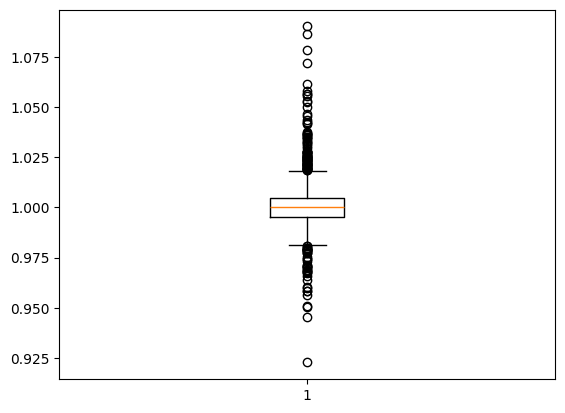

In [237]:
#checking that the transacted prices are now in realm of where we expect them to be
piv_table['diff_to_executed']=piv_table['transacted_avg']/piv_table['STOCK_t0']
plt.boxplot(x=piv_table['diff_to_executed'])

## I will now create an index of the returns from random periods


In [238]:
piv_table

,TRANS_DATE,ISSUERTRADINGSYMBOL,TRANS_SHARES,value_transacted,direction,transacted_avg,STOCK_-1,STOCK_t0,STOCK_t1,STOCK_t2,STOCK_t3,STOCK_t4,STOCK_t5,max,min,is_above_min,is_below_max,diff_to_executed
0,2024-06-27,ABNB,11635.00,1745482.70,S,150.020000,150.000000,151.610001,151.630005,151.630005,154.339996,152.729996,152.500000,154.339996,150.000000,True,True,0.989513
1,2024-06-27,ADSK,75.00,18316.50,S,244.220000,243.279999,243.679993,247.449997,245.830002,247.860001,246.300003,247.869995,247.869995,243.279999,True,True,1.002216
2,2024-06-27,AMZN,4710.00,918450.00,S,195.000000,193.610001,197.850006,193.250000,197.199997,200.000000,197.589996,200.000000,200.000000,193.250000,True,True,0.985595
3,2024-06-27,ANET,25000.00,8675000.00,S,347.000000,334.700012,347.929993,350.480011,356.700012,357.010010,365.420013,366.140015,366.140015,334.700012,True,True,0.997327
4,2024-06-27,JNPR,40000.00,1440000.00,S,36.000000,35.689999,36.009998,36.459999,36.750000,36.570000,36.349998,36.720001,36.750000,35.689999,True,True,0.999722
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1780,2024-09-10,APTV,14475.00,967026.00,P,66.806632,69.080002,65.379997,65.470001,67.000000,68.949997,68.790001,70.220001,70.220001,65.379997,True,True,1.021821
1781,2024-09-10,DG,1000.00,80825.00,P,80.825000,80.980003,80.690002,80.570000,83.209999,84.750000,85.750000,86.010002,86.010002,80.570000,True,True,1.001673
1782,2024-09-10,HLT,4750.00,1001369.39,P,210.814608,214.940002,210.649994,211.580002,216.130005,216.820007,218.100006,220.380005,220.380005,210.649994,True,True,1.000781
1785,2024-09-13,WY,7800.00,249678.00,P,32.010000,31.410000,32.450001,32.509998,33.250000,33.099998,33.590000,33.240002,33.590000,31.410000,True,True,0.986441


In [239]:
#make a copy of the dataframe
piv_table_control=piv_table.copy()

In [240]:
# We will make a column called is_control so we can later concat the dataframes
piv_table['is_control']="False"
piv_table

,TRANS_DATE,ISSUERTRADINGSYMBOL,TRANS_SHARES,value_transacted,direction,transacted_avg,STOCK_-1,STOCK_t0,STOCK_t1,STOCK_t2,STOCK_t3,STOCK_t4,STOCK_t5,max,min,is_above_min,is_below_max,diff_to_executed,is_control
0,2024-06-27,ABNB,11635.00,1745482.70,S,150.020000,150.000000,151.610001,151.630005,151.630005,154.339996,152.729996,152.500000,154.339996,150.000000,True,True,0.989513,False
1,2024-06-27,ADSK,75.00,18316.50,S,244.220000,243.279999,243.679993,247.449997,245.830002,247.860001,246.300003,247.869995,247.869995,243.279999,True,True,1.002216,False
2,2024-06-27,AMZN,4710.00,918450.00,S,195.000000,193.610001,197.850006,193.250000,197.199997,200.000000,197.589996,200.000000,200.000000,193.250000,True,True,0.985595,False
3,2024-06-27,ANET,25000.00,8675000.00,S,347.000000,334.700012,347.929993,350.480011,356.700012,357.010010,365.420013,366.140015,366.140015,334.700012,True,True,0.997327,False
4,2024-06-27,JNPR,40000.00,1440000.00,S,36.000000,35.689999,36.009998,36.459999,36.750000,36.570000,36.349998,36.720001,36.750000,35.689999,True,True,0.999722,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1780,2024-09-10,APTV,14475.00,967026.00,P,66.806632,69.080002,65.379997,65.470001,67.000000,68.949997,68.790001,70.220001,70.220001,65.379997,True,True,1.021821,False
1781,2024-09-10,DG,1000.00,80825.00,P,80.825000,80.980003,80.690002,80.570000,83.209999,84.750000,85.750000,86.010002,86.010002,80.570000,True,True,1.001673,False
1782,2024-09-10,HLT,4750.00,1001369.39,P,210.814608,214.940002,210.649994,211.580002,216.130005,216.820007,218.100006,220.380005,220.380005,210.649994,True,True,1.000781,False
1785,2024-09-13,WY,7800.00,249678.00,P,32.010000,31.410000,32.450001,32.509998,33.250000,33.099998,33.590000,33.240002,33.590000,31.410000,True,True,0.986441,False


In [241]:
#set up piv_table_control so we can fill it with data from same stocks on different days
piv_table_control['is_control']="True"
piv_table_control['transacted_avg']=np.nan
piv_table_control['value_transacted']=np.nan
piv_table_control['is_above_min']=np.nan
piv_table_control['is_below_max']=np.nan
piv_table_control['diff_to_executed']=np.nan

piv_table_control['STOCK_-1']=np.nan
piv_table_control['STOCK_t0']=np.nan
piv_table_control['STOCK_t1']=np.nan
piv_table_control['STOCK_t2']=np.nan
piv_table_control['STOCK_t3']=np.nan
piv_table_control['STOCK_t4']=np.nan
piv_table_control['STOCK_t5']=np.nan

piv_table

,TRANS_DATE,ISSUERTRADINGSYMBOL,TRANS_SHARES,value_transacted,direction,transacted_avg,STOCK_-1,STOCK_t0,STOCK_t1,STOCK_t2,STOCK_t3,STOCK_t4,STOCK_t5,max,min,is_above_min,is_below_max,diff_to_executed,is_control
0,2024-06-27,ABNB,11635.00,1745482.70,S,150.020000,150.000000,151.610001,151.630005,151.630005,154.339996,152.729996,152.500000,154.339996,150.000000,True,True,0.989513,False
1,2024-06-27,ADSK,75.00,18316.50,S,244.220000,243.279999,243.679993,247.449997,245.830002,247.860001,246.300003,247.869995,247.869995,243.279999,True,True,1.002216,False
2,2024-06-27,AMZN,4710.00,918450.00,S,195.000000,193.610001,197.850006,193.250000,197.199997,200.000000,197.589996,200.000000,200.000000,193.250000,True,True,0.985595,False
3,2024-06-27,ANET,25000.00,8675000.00,S,347.000000,334.700012,347.929993,350.480011,356.700012,357.010010,365.420013,366.140015,366.140015,334.700012,True,True,0.997327,False
4,2024-06-27,JNPR,40000.00,1440000.00,S,36.000000,35.689999,36.009998,36.459999,36.750000,36.570000,36.349998,36.720001,36.750000,35.689999,True,True,0.999722,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1780,2024-09-10,APTV,14475.00,967026.00,P,66.806632,69.080002,65.379997,65.470001,67.000000,68.949997,68.790001,70.220001,70.220001,65.379997,True,True,1.021821,False
1781,2024-09-10,DG,1000.00,80825.00,P,80.825000,80.980003,80.690002,80.570000,83.209999,84.750000,85.750000,86.010002,86.010002,80.570000,True,True,1.001673,False
1782,2024-09-10,HLT,4750.00,1001369.39,P,210.814608,214.940002,210.649994,211.580002,216.130005,216.820007,218.100006,220.380005,220.380005,210.649994,True,True,1.000781,False
1785,2024-09-13,WY,7800.00,249678.00,P,32.010000,31.410000,32.450001,32.509998,33.250000,33.099998,33.590000,33.240002,33.590000,31.410000,True,True,0.986441,False


In [242]:
#Set range for the random trade dates (max is 2024-09-30, min is  2024-06-27)
piv_table_control['TRANS_DATE'].describe()
piv_table


,TRANS_DATE,ISSUERTRADINGSYMBOL,TRANS_SHARES,value_transacted,direction,transacted_avg,STOCK_-1,STOCK_t0,STOCK_t1,STOCK_t2,STOCK_t3,STOCK_t4,STOCK_t5,max,min,is_above_min,is_below_max,diff_to_executed,is_control
0,2024-06-27,ABNB,11635.00,1745482.70,S,150.020000,150.000000,151.610001,151.630005,151.630005,154.339996,152.729996,152.500000,154.339996,150.000000,True,True,0.989513,False
1,2024-06-27,ADSK,75.00,18316.50,S,244.220000,243.279999,243.679993,247.449997,245.830002,247.860001,246.300003,247.869995,247.869995,243.279999,True,True,1.002216,False
2,2024-06-27,AMZN,4710.00,918450.00,S,195.000000,193.610001,197.850006,193.250000,197.199997,200.000000,197.589996,200.000000,200.000000,193.250000,True,True,0.985595,False
3,2024-06-27,ANET,25000.00,8675000.00,S,347.000000,334.700012,347.929993,350.480011,356.700012,357.010010,365.420013,366.140015,366.140015,334.700012,True,True,0.997327,False
4,2024-06-27,JNPR,40000.00,1440000.00,S,36.000000,35.689999,36.009998,36.459999,36.750000,36.570000,36.349998,36.720001,36.750000,35.689999,True,True,0.999722,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1780,2024-09-10,APTV,14475.00,967026.00,P,66.806632,69.080002,65.379997,65.470001,67.000000,68.949997,68.790001,70.220001,70.220001,65.379997,True,True,1.021821,False
1781,2024-09-10,DG,1000.00,80825.00,P,80.825000,80.980003,80.690002,80.570000,83.209999,84.750000,85.750000,86.010002,86.010002,80.570000,True,True,1.001673,False
1782,2024-09-10,HLT,4750.00,1001369.39,P,210.814608,214.940002,210.649994,211.580002,216.130005,216.820007,218.100006,220.380005,220.380005,210.649994,True,True,1.000781,False
1785,2024-09-13,WY,7800.00,249678.00,P,32.010000,31.410000,32.450001,32.509998,33.250000,33.099998,33.590000,33.240002,33.590000,31.410000,True,True,0.986441,False


## Now we will work with the dataFrame 'data' to make a control set there as well 

In [243]:
#We will now make a new index that we can later reference

data_control=data
ref=-1
for idx, row in data_control.iterrows():
    ref=ref+1  
    data_control.loc[idx,"ref_num"]=ref




In [244]:
#we will pull out the dates as our index and replace them with our ref_num

data_control['Date']=data_control.index
data_control= data_control.set_index('ref_num')

In [245]:
# we now know we need the ref numbers 150-216 (which is same as our iloc) these correspond to dates 2024-06-27 to 2024-09-30
data_control.iloc[150:216,:]

Ticker,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WM,WMT,WST,WY,WYNN,XEL,XYL,YUM,ZBRA,Date
ref_num,,,,,,,,,,,,,,,,,,,,,
150.0,130.800003,214.100006,168.990005,151.610001,104.650002,101.019997,303.190002,546.760010,226.679993,60.610001,...,212.669998,67.879997,328.760010,28.219999,89.139999,53.849998,136.389999,132.610001,306.989990,2024-06-27
151.0,129.630005,210.619995,171.520004,151.630005,103.910004,100.889999,303.410004,555.539978,228.259995,60.450001,...,213.339996,67.709999,329.390015,28.389999,89.500000,53.410000,135.630005,132.460007,308.929993,2024-06-28
152.0,127.400002,216.750000,170.369995,151.630005,103.199997,100.650002,302.549988,560.010010,225.179993,60.639999,...,209.360001,67.480003,324.549988,27.559999,87.669998,52.430000,131.529999,129.699997,306.209991,2024-07-01
153.0,125.779999,220.270004,165.960007,154.339996,103.199997,100.000000,303.829987,567.710022,228.240005,62.130001,...,209.470001,68.070000,322.600006,27.480000,86.330002,53.200001,132.270004,130.029999,310.029999,2024-07-02
154.0,126.129997,221.550003,163.839996,152.729996,102.330002,97.650002,305.750000,570.150024,230.020004,62.689999,...,210.199997,68.239998,320.899994,27.049999,87.279999,52.750000,132.710007,129.580002,312.850006,2024-07-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211.0,141.869995,227.369995,193.509995,131.479996,113.339996,113.349998,339.619995,524.070007,227.330002,60.730000,...,207.520004,80.669998,309.709991,33.779999,84.160004,64.169998,133.039993,133.800003,364.429993,2024-09-24
212.0,139.440002,226.369995,191.259995,130.710007,112.610001,113.070000,337.049988,517.900024,226.639999,58.139999,...,207.690002,81.400002,303.329987,32.970001,84.129997,64.190002,133.610001,133.089996,364.970001,2024-09-25
213.0,146.740005,227.520004,191.899994,129.250000,112.730003,112.570000,355.809998,515.380005,232.460007,59.369999,...,205.339996,79.919998,307.140015,33.160000,91.029999,63.980000,134.130005,138.070007,371.239990,2024-09-26


In [246]:
#we will now shift this data set so that we can pull t prices easily

data_neg_1_control=data_control.shift(periods=1)
data_1_control=data_control.shift(periods=-1)
data_2_control=data_control.shift(periods=-2)
data_3_control=data_control.shift(periods=-3)
data_4_control=data_control.shift(periods=-4)
data_5_control=data_control.shift(periods=-5)

In [247]:
#we will now go back to pivot_table_control to give some random dates to our transactions
#we will now assign a random time variable within our reference range of dates from 150-216 correponding to ref and the period sampled.
random.seed(42)


for idx, row in piv_table_control.iterrows():
    a=random.randrange(start=150, stop=216, step=1)
    piv_table_control.loc[idx,'random_date_index']=int(a)


piv_table_control




,TRANS_DATE,ISSUERTRADINGSYMBOL,TRANS_SHARES,value_transacted,direction,transacted_avg,STOCK_-1,STOCK_t0,STOCK_t1,STOCK_t2,STOCK_t3,STOCK_t4,STOCK_t5,max,min,is_above_min,is_below_max,diff_to_executed,is_control,random_date_index
0,2024-06-27,ABNB,11635.00,NaN,S,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,154.339996,150.000000,NaN,NaN,NaN,True,164.0
1,2024-06-27,ADSK,75.00,NaN,S,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,247.869995,243.279999,NaN,NaN,NaN,True,153.0
2,2024-06-27,AMZN,4710.00,NaN,S,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,200.000000,193.250000,NaN,NaN,NaN,True,185.0
3,2024-06-27,ANET,25000.00,NaN,S,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,366.140015,334.700012,NaN,NaN,NaN,True,181.0
4,2024-06-27,JNPR,40000.00,NaN,S,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36.750000,35.689999,NaN,NaN,NaN,True,178.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1780,2024-09-10,APTV,14475.00,NaN,P,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.220001,65.379997,NaN,NaN,NaN,True,168.0
1781,2024-09-10,DG,1000.00,NaN,P,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,86.010002,80.570000,NaN,NaN,NaN,True,187.0
1782,2024-09-10,HLT,4750.00,NaN,P,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,220.380005,210.649994,NaN,NaN,NaN,True,204.0
1785,2024-09-13,WY,7800.00,NaN,P,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.590000,31.410000,NaN,NaN,NaN,True,150.0


In [248]:
# I will now remove the dates
piv_table_control['TRANS_DATE']=np.nan

In [249]:
## We now go back to pivot_table_control to import the random data

In [250]:
#we will now use itterows to iterate throught to make our pivot table with our new values

#calc t-1 (day before the transaction)

for idx, row in  piv_table_control.iterrows():
    index_ref=int(row['random_date_index'])
    symbol= row['ISSUERTRADINGSYMBOL'] 
    try:
        value=data_neg_1_control.iloc[index_ref][symbol]
        piv_table_control.loc[idx,"STOCK_-1"]=value
    except:
        piv_table_control.loc[idx,"STOCK_-1"]=np.nan



#calc t0 (day of the transaction)
#here I am also calculating what the random date is via the index

for idx, row in  piv_table_control.iterrows():
    index_ref=int(row['random_date_index'])
    symbol= row['ISSUERTRADINGSYMBOL']
     
    value=data_control.iloc[index_ref][symbol]
    piv_table_control.loc[idx,"STOCK_t0"]=value

    date=data_control.iloc[index_ref]['Date']
    piv_table_control.loc[idx,'TRANS_DATE']=date


#calc t+1 (day after  the transaction)
for idx, row in  piv_table_control.iterrows():
    index_ref=int(row['random_date_index'])
    symbol= row['ISSUERTRADINGSYMBOL']
    try:    
        value=data_1_control.iloc[index_ref][symbol]
        piv_table_control.loc[idx,"STOCK_t1"]=value
    except:
        piv_table_control.loc[idx,"STOCK_t1"]=np.nan

#calc t+2 (day 2 after  the transaction)        

for idx, row in  piv_table_control.iterrows():
    index_ref=int(row['random_date_index'])
    symbol= row['ISSUERTRADINGSYMBOL']
    try:    
        value=data_2_control.iloc[index_ref][symbol]
        piv_table_control.loc[idx,"STOCK_t2"]=value
    except:
        piv_table_control.loc[idx,"STOCK_t2"]=np.nan


#calc t+3 (day 3 after the transaction)   
for idx, row in  piv_table_control.iterrows():
    index_ref=int(row['random_date_index'])
    symbol= row['ISSUERTRADINGSYMBOL']
    try:    
        value=data_3_control.iloc[index_ref][symbol]
        piv_table_control.loc[idx,"STOCK_t3"]=value
    except:
        piv_table_control.loc[idx,"STOCK_t3"]=np.nan      


#calc t+4 (day 4 after the transaction)   
for idx, row in  piv_table_control.iterrows():
    index_ref=int(row['random_date_index'])
    symbol= row['ISSUERTRADINGSYMBOL']
    try:    
        value=data_4_control.iloc[index_ref][symbol]
        piv_table_control.loc[idx,"STOCK_t4"]=value
    except:
        piv_table_control.loc[idx,"STOCK_t4"]=np.nan    

#calc t+5 (day 5 after the transaction)   
for idx, row in  piv_table_control.iterrows():
    index_ref=int(row['random_date_index'])
    symbol= row['ISSUERTRADINGSYMBOL']
    try:    
        value=data_5_control.iloc[index_ref][symbol]
        piv_table_control.loc[idx,"STOCK_t5"]=value
    except:
        piv_table_control.loc[idx,"STOCK_t5"]=np.nan   



C:\Users\maria\AppData\Local\Temp\ipykernel_27536\992004216.py:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2024-07-18 00:00:00' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  piv_table_control.loc[idx,'TRANS_DATE']=date


In [251]:
piv_table_control.head(3)

,TRANS_DATE,ISSUERTRADINGSYMBOL,TRANS_SHARES,value_transacted,direction,transacted_avg,STOCK_-1,STOCK_t0,STOCK_t1,STOCK_t2,STOCK_t3,STOCK_t4,STOCK_t5,max,min,is_above_min,is_below_max,diff_to_executed,is_control,random_date_index
0,2024-07-18 00:00:00,ABNB,11635.0,NaN,S,NaN,148.000000,146.880005,147.990005,150.179993,148.750000,144.229996,140.029999,154.339996,150.000000,NaN,NaN,NaN,True,164.0
1,2024-07-02 00:00:00,ADSK,75.0,NaN,S,NaN,245.830002,247.860001,246.300003,247.869995,247.960007,243.960007,247.050003,247.869995,243.279999,NaN,NaN,NaN,True,153.0
2,2024-08-16 00:00:00,AMZN,4710.0,NaN,S,NaN,177.589996,177.059998,178.220001,178.880005,180.110001,176.130005,177.039993,200.000000,193.250000,NaN,NaN,NaN,True,185.0


In [252]:
piv_table['random_date_index']=np.nan
piv_table.head(3)

,TRANS_DATE,ISSUERTRADINGSYMBOL,TRANS_SHARES,value_transacted,direction,transacted_avg,STOCK_-1,STOCK_t0,STOCK_t1,STOCK_t2,STOCK_t3,STOCK_t4,STOCK_t5,max,min,is_above_min,is_below_max,diff_to_executed,is_control,random_date_index
0,2024-06-27,ABNB,11635.0,1745482.7,S,150.02,150.000000,151.610001,151.630005,151.630005,154.339996,152.729996,152.500000,154.339996,150.000000,True,True,0.989513,False,NaN
1,2024-06-27,ADSK,75.0,18316.5,S,244.22,243.279999,243.679993,247.449997,245.830002,247.860001,246.300003,247.869995,247.869995,243.279999,True,True,1.002216,False,NaN
2,2024-06-27,AMZN,4710.0,918450.0,S,195.00,193.610001,197.850006,193.250000,197.199997,200.000000,197.589996,200.000000,200.000000,193.250000,True,True,0.985595,False,NaN


In [253]:
stock_prices=pd.concat([piv_table,piv_table_control],ignore_index=True)
stock_prices

,TRANS_DATE,ISSUERTRADINGSYMBOL,TRANS_SHARES,value_transacted,direction,transacted_avg,STOCK_-1,STOCK_t0,STOCK_t1,STOCK_t2,STOCK_t3,STOCK_t4,STOCK_t5,max,min,is_above_min,is_below_max,diff_to_executed,is_control,random_date_index
0,2024-06-27 00:00:00,ABNB,11635.00,1745482.7,S,150.02,150.000000,151.610001,151.630005,151.630005,154.339996,152.729996,152.500000,154.339996,150.000000,1.0,1.0,0.989513,False,NaN
1,2024-06-27 00:00:00,ADSK,75.00,18316.5,S,244.22,243.279999,243.679993,247.449997,245.830002,247.860001,246.300003,247.869995,247.869995,243.279999,1.0,1.0,1.002216,False,NaN
2,2024-06-27 00:00:00,AMZN,4710.00,918450.0,S,195.00,193.610001,197.850006,193.250000,197.199997,200.000000,197.589996,200.000000,200.000000,193.250000,1.0,1.0,0.985595,False,NaN
3,2024-06-27 00:00:00,ANET,25000.00,8675000.0,S,347.00,334.700012,347.929993,350.480011,356.700012,357.010010,365.420013,366.140015,366.140015,334.700012,1.0,1.0,0.997327,False,NaN
4,2024-06-27 00:00:00,JNPR,40000.00,1440000.0,S,36.00,35.689999,36.009998,36.459999,36.750000,36.570000,36.349998,36.720001,36.750000,35.689999,1.0,1.0,0.999722,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2897,2024-07-24 00:00:00,APTV,14475.00,NaN,P,NaN,68.589996,67.080002,67.830002,68.739998,68.900002,67.629997,69.389999,70.220001,65.379997,NaN,NaN,NaN,True,168.0
2898,2024-08-20 00:00:00,DG,1000.00,NaN,P,NaN,122.089996,121.589996,123.709999,123.239998,123.599998,124.339996,125.120003,86.010002,80.570000,NaN,NaN,NaN,True,187.0
2899,2024-09-13 00:00:00,HLT,4750.00,NaN,P,NaN,216.130005,216.820007,218.100006,220.380005,220.979996,225.539993,224.639999,220.380005,210.649994,NaN,NaN,NaN,True,204.0
2900,2024-06-27 00:00:00,WY,7800.00,NaN,P,NaN,27.959999,28.219999,28.389999,27.559999,27.480000,27.049999,27.450001,33.590000,31.410000,NaN,NaN,NaN,True,150.0


In [254]:
stock_prices.to_csv("/Users/maria/Desktop/csv_files/stock_prices.csv",index=True, sep=',')
